In [213]:
%autosave 1
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as stats


Autosaving every 1 seconds


## PV with square activation function and square in learning rule

In [214]:
def phi_square(_x):
    x = np.array([_x])
    x[x<=0] = 0
    x[x>0] = (x[x>0])**2 
    x[x>20] = 20
    return x[0]

In [215]:
def phi_RL(_x):
    """rectified linear activation function"""
    x = np.array([_x])
    x[x<=0] = 0
    x[x>20] = 20
    return x[0]

In [216]:
def phi(x_,case=1):
    x = np.array([x_])
    if case == 1:
        x[x<=0] = 0
        x[x>20] = 20
    return x[0]
    

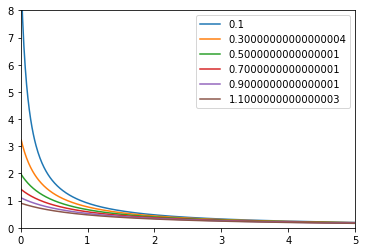

In [217]:
x = np.arange(0.01,20,0.01)
for offset in np.arange(0.1,1.2,0.2):
    plt.plot(x,(1/(offset+x)),label=str(offset))
plt.xlim(0,5)
plt.ylim(0,8)
plt.legend()

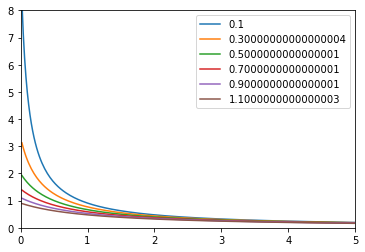

In [218]:
x = np.arange(0.01,20,0.01)
for offset in np.arange(0.1,1.2,0.2):
    plt.plot(2*x,(1/(offset+2*x)),label=str(offset))
plt.xlim(0,5)
plt.ylim(0,8)
plt.legend()

In [233]:
def run_network(mean= 5.0, sigma= 0.5, wP= 6.0, w_init_PV_P = 0.01,  w_init_PV_N = 0.01, w_init_R = 0.1, plastic=True, plastic_PV=True, uncertainty_weighted=1, unscaled=False, rectified=1):
    """
    Parameters
    ----------
    mean : float
        mean of the stimulus distribution
    sigma: float
        standard deviation of the stimulus distribution
    wP : float
        connection weight from R to PV and from SST to PV
    w_init_PV : float
        initial weight from Y1 to PV
    w_init_R : float
        initial weight from Y1 to R
    plastic : boolean
        truth value indicates whether plasticity is switched on or off   
        
    Returns
    ----------
    E_avg : float
        mean rate of error neuron
    PV_avg : float
        mean rate of PV
    SST_avg : float
        mean rate of SST
    R_avg : float
        mean rate of R
    wPX1_monitor : array of length t
        weight from X1 to PV over the course of the simulation
    wRX1_monitor : array of length t
        weight from X1 to R over the course of the simulation
    rE_monitor : array of length t
        rate of error neuron over the course of the simulation
    rS_monitor : array of length t
        rate of error neuron over the course of the simulation
    rP_monitor : array of length t
        rate of error neuron over the course of the simulation
    rY1 : array of length t
        whisker deflections over the course of the simulation
    """
    
    #sim parameters
    dt = 1
    T = 300000 # number of time steps

    # time constants
    tau_P = 1.0
    tau_S = 1.0
    tau_E = 1.0
    tau_R = 1.0

    # weights
    w_init = 0.01
    # to Representation neuron
    wRX1 = np.array([w_init_R]) # small intitial weight
    #wRY1 = np.array([1.0])
    wRE_P = np.array([1.0])
    wRE_N = np.array([1.0])

    
    # weights in positive PE circuit
    # to PV
    wPX1_P = np.array([w_init_PV_P]) # small intitial weights
    wPY1_P = np.array([wP]) # small intitial weights
    wPS_P = np.array([w_init])
    
    # to SST
    wSR_P = np.array([1.0])

    # to E
    wEP_P = np.array([1.0])
    wES_P = np.array([1.0])
    wEY1_P = np.array([1.0])
    
    # weights in negative PE circuit
    # to PV
    wPR_N = np.array([wP])
    wPX1_N = np.array([w_init_PV_N]) # small intitial weights
    wPS_N = np.array([w_init])
    
    # to SST
    wSY1_N = np.array([1.0])

    # to E
    wEP_N = np.array([1.0])
    wES_N = np.array([1.0])
    wER_N = np.array([1.0])

    # nudging parameter
    beta_R = 0.1 
    beta_P = 0.1


    # inputs
    # sound
    rX1 = np.ones((T))

    # whisker
    Y1_mean = mean
    Y1_sigma = sigma

    rY1 = Y1_sigma*np.random.randn(T)+Y1_mean

    #learning rate
    eta_R = 0.1
    eta_P = 0.001
    eta_ES = 0.001
    eta_ES_N = 0.001
    eta_RE = 0.001

    #initial rates
    rP_P = 0.0#phi_square(rB[0])
    rS_P = 0.0
    rE_P = 0.0
    rE_patho = 0.0
    rP_N = 0.0#phi_square(rB[0])
    rS_N = 0.0
    rE_N = 0.0
    
    rR = 0.0

    # monitors
    rP_P_monitor = np.empty((T))
    rE_P_monitor = np.empty((T))
    rE_patho_monitor = np.empty((T))
    rS_P_monitor = np.empty((T))
    rP_N_monitor = np.empty((T))
    rE_N_monitor = np.empty((T))
    rS_N_monitor = np.empty((T))
    
    rR_monitor = np.empty((T))

    wPX1_P_monitor = np.empty((T))
    wPX1_N_monitor = np.empty((T))
    wRX1_monitor = np.empty((T))
    wPS_P_monitor = np.empty((T))
    wPS_N_monitor = np.empty((T))
    wES_P_monitor = np.empty((T))
    wES_N_monitor = np.empty((T))
    wRE_P_monitor = np.empty((T))
    wRE_N_monitor = np.empty((T))
    
    PV_in_target = np.empty((T))
    PV_in_wX = np.empty((T))
    PV_in = np.empty((T))
    PV_deltaw = np.empty((T))
    

    for t in range(T):

        
        drS_P = (-rS_P + phi_RL(wSR_P * rR))/tau_S
        drP_P = (-rP_P + phi_square(((1-beta_P)*(wPX1_P * rX1[t]) + beta_P*(wPY1_P * rY1[t] - wPS_P * rS_P))))/tau_P
        drE_P = (-rE_P + phi(1.0/(0.3 + uncertainty_weighted*(wEP_P * rP_P) + unscaled*0.7) * (wEY1_P * rY1[t] - wES_P * rS_P),case=rectified))/tau_E
        if t%10000==0:
            print('uncertainty_weighted')
            print(uncertainty_weighted*(wEP_P * rP_P))
            print('unscaled')
            print(unscaled*0.7)
            
        drS_N = (-rS_N + phi_RL(+ wSY1_N * rY1[t]))/tau_S
        drP_N = (-rP_N + phi_square(((1-beta_P)*(wPX1_N * rX1[t]) + beta_P*(wPR_N * rR - wPS_N * rS_N))))/tau_P
        drE_N = (-rE_N + phi(1.0/(0.3 + uncertainty_weighted*(wEP_N * rP_N) + unscaled*0.7) * (wER_N * rR - wES_N * rS_N),case=rectified))/tau_E

        drR = (-rR + phi_RL((wRX1 * rX1[t]) + (wRE_P * rE_P) - (wRE_N * rE_N)))/tau_R # no convex combination, input from error neuron
                
        
        # store monitors
        rP_P_monitor[t] = rP_P
        rS_P_monitor[t] = rS_P
        rE_P_monitor[t] = rE_P
        rE_patho_monitor[t] = rE_patho
        rP_N_monitor[t] = rP_N
        rS_N_monitor[t] = rS_N
        rE_N_monitor[t] = rE_N
        rR_monitor[t] = rR
        wPX1_P_monitor[t] = wPX1_P
        wPX1_N_monitor[t] = wPX1_N
        wRX1_monitor[t] = wRX1
        wPS_P_monitor[t] = wPS_P
        wPS_N_monitor[t] = wPS_N
        wES_P_monitor[t] = wES_P
        wES_N_monitor[t] = wES_N
        wRE_P_monitor[t] = wRE_P
        wRE_N_monitor[t] = wRE_N

        PV_in_target[t] = beta_P*(wPY1_P * rY1[t] + wPS_P * rS_P)
        PV_in_wX[t] = (1-beta_P)*(wPX1_P * rX1[t])


        # rate changes
        rP_P += dt*drP_P
        rS_P += dt*drS_P
        rE_P += dt*drE_P
        rP_N += dt*drP_N
        rS_N += dt*drS_N
        rE_N += dt*drE_N
        rR += dt*drR

        # weight changes
        if t > 100:
            wPX1_P += plastic_PV * eta_P * ((rP_P - ((wPX1_P*rX1[t])**2)) * rX1[t])
            wPX1_N += plastic_PV * eta_P * ((rP_N - ((wPX1_N*rX1[t])**2)) * rX1[t])
            #print(plastic * eta_P * ((rP_P - ((wPX1*rX1[t])**2)) * rX1[t]))
            wRX1 += plastic * eta_R * ((rR - (wRX1*rX1[t])) * rX1[t])
            wPS_P += plastic * eta_P * ((wPY1_P * rY1[t] - wPS_P * rS_P)-0)*rS_P
            wPS_N += plastic * eta_P * ((wPR_N * rR - wPS_N * rS_N)-0)*rS_N
            #wES_N += plastic * eta_ES_N * ((wER_N * rR - wES_N * rS_N)-0)*rS_N
            #wES_P += plastic * eta_ES * ((wEY1_P * rY1[t] - wES_P * rS_P)-0)*rS_P
            #wRE_P += plastic * eta_RE * (wRE_P*rE_P - wRE_N*rE_N) * rE_P
            #wRE_N += plastic * eta_RE * (wRE_P*rE_P - wRE_N*rE_N) * rE_N

            PV_deltaw[t] = rP_P - ((wPX1_P*rX1[t])**2)
        PV_in[t] = (wPX1_P*rX1[t])**2
    
    results = {
    'PV_P_avg' : np.mean(rP_P_monitor[100:]),
    'SST_P_avg': np.mean(rS_P_monitor[100:]),
    'E_P_avg' : np.mean(rE_P_monitor[100:]),
    'R_avg' : np.mean(rR_monitor[100:]),
    'PV_N_avg' : np.mean(rP_N_monitor[100:]),
    'SST_N_avg' : np.mean(rS_N_monitor[100:]),
    'E_N_avg' : np.mean(rE_N_monitor[100:]),
    'PV_P_std' : np.std(rP_P_monitor[100:]),
    'SST_P_std': np.std(rS_P_monitor[100:]),
    'E_P_std' : np.std(rE_P_monitor[100:]),
    'R_std' : np.std(rR_monitor[100:]),
    'PV_N_std' : np.std(rP_N_monitor[100:]),
    'SST_N_std' : np.std(rS_N_monitor[100:]),
    'E_N_std' : np.std(rE_N_monitor[100:]),        
    'wPX1_P' : wPX1_P_monitor, 
    'wPX1_N' : wPX1_N_monitor, 
    'wRX1' : wRX1_monitor, 
    'wPS_P' : wPS_P_monitor, 
    'wPS_N' : wPS_N_monitor, 
    'wES_P' : wES_P_monitor, 
    'wES_N' : wES_N_monitor, 
    'wRE_P' : wRE_P_monitor, 
    'wRE_N' : wRE_N_monitor, 
    'rE_P' : rE_P_monitor, 
    'rS_P' : rS_P_monitor, 
    'rP_P' : rP_P_monitor, 
    'rE_N' : rE_N_monitor, 
    'rS_N' : rS_N_monitor, 
    'rP_N' : rP_N_monitor, 
    'rR' : rR_monitor, 
    'rY1' : rY1,
    'PV_in_target' : PV_in_target,
    'PV_in_wX' : PV_in_wX,
    'PV_deltaw' : PV_deltaw,
    'PV_in' : PV_in
    }
    

    return results
    

#### Run network without rectification: results1n

In [152]:
Y1_mean = 5.0
Y2_mean = 5.0
Y1_sigma = 1.0
Y2_sigma = 0.4
results1n = run_network(mean= Y1_mean,sigma=Y1_sigma,rectified=0)
results2n = run_network(mean= Y2_mean,sigma=Y2_sigma,rectified=0)



KeyboardInterrupt: 

In [ ]:
#### Run network with rectification: results1r

In [234]:
Y1_mean = 5.0
Y2_mean = 5.0
Y1_sigma = 0.6
Y2_sigma = 0.1

#results1r = run_network(mean= Y1_mean, sigma=Y1_sigma, w_init_PV_P = results1['wPX1_P'][-1], w_init_PV_N = results1['wPX1_N'][-1], plastic_PV=False, patho=False,rectified=1)
#results2r = run_network(mean= Y2_mean, sigma=Y2_sigma, w_init_PV_P = results2['wPX1_P'][-1], w_init_PV_N = results2['wPX1_N'][-1], plastic_PV=False, patho=False,rectified=1)
results1r = run_network(mean= Y1_mean, sigma=Y1_sigma,rectified=1)
results2r = run_network(mean= Y2_mean, sigma=Y2_sigma,rectified=1)



uncertainty_weighted
[0.]
unscaled
0.0
uncertainty_weighted
[0.60179697]
unscaled
0.0
uncertainty_weighted
[3.02874318]
unscaled
0.0
uncertainty_weighted
[9.34098536]
unscaled
0.0
uncertainty_weighted
[3.18494185]
unscaled
0.0
uncertainty_weighted
[3.15094475]
unscaled
0.0
uncertainty_weighted
[2.23583523]
unscaled
0.0
uncertainty_weighted
[1.79195007]
unscaled
0.0
uncertainty_weighted
[1.55223772]
unscaled
0.0
uncertainty_weighted
[0.24307259]
unscaled
0.0
uncertainty_weighted
[1.0633991]
unscaled
0.0
uncertainty_weighted
[0.42932951]
unscaled
0.0
uncertainty_weighted
[0.72000308]
unscaled
0.0
uncertainty_weighted
[1.51993955]
unscaled
0.0
uncertainty_weighted
[1.72916967]
unscaled
0.0
uncertainty_weighted
[0.95910113]
unscaled
0.0
uncertainty_weighted
[4.10393436]
unscaled
0.0
uncertainty_weighted
[4.07702659]
unscaled
0.0
uncertainty_weighted
[0.89185807]
unscaled
0.0
uncertainty_weighted
[2.78088369]
unscaled
0.0
uncertainty_weighted
[2.6493001]
unscaled
0.0
uncertainty_weighted
[1

In [224]:
Y4_mean = 5.0
Y4_sigma = 1.0
results4r = run_network(mean= Y4_mean, sigma=Y4_sigma,rectified=1)


In [ ]:
#### Run network without uncertainty weighting: results1rp

In [235]:
Y1_mean = 5.0
Y2_mean = 5.0
Y1_sigma = 0.6
Y2_sigma = 0.1
#results1r = run_network(mean= Y1_mean, sigma=Y1_sigma, w_init_PV_P = results1['wPX1_P'][-1], w_init_PV_N = results1['wPX1_N'][-1], plastic_PV=False, patho=False,rectified=1)
#results2r = run_network(mean= Y2_mean, sigma=Y2_sigma, w_init_PV_P = results2['wPX1_P'][-1], w_init_PV_N = results2['wPX1_N'][-1], plastic_PV=False, patho=False,rectified=1)
results1rp = run_network(mean= Y1_mean, sigma=Y1_sigma, uncertainty_weighted=0, unscaled=True, rectified=1)
results2rp = run_network(mean= Y2_mean, sigma=Y2_sigma, uncertainty_weighted=0, unscaled=True, rectified=1)

uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]
unscaled
0.7
uncertainty_weighted
[0.]

In [ ]:
#### Run network with very low uncertainty:

In [497]:
Y3_mean = 5
Y3_sigma = 0.01
results3r = run_network(mean=Y3_mean, sigma=Y3_sigma, rectified=1)
results3rp = run_network(mean=Y3_mean, sigma=Y3_sigma, uncertainty_weighted=0, rectified=1)

In [ ]:
#### Run network with learned weights and new mean: +4

In [225]:
results1_new = run_network(mean= Y1_mean+4, sigma=Y1_sigma, w_init_PV_P = results1r['wPX1_P'][-1], w_init_PV_N = results1r['wPX1_N'][-1], w_init_R = results1r['wRX1'][-1], rectified=1)
results2_new = run_network(mean= Y2_mean+4, sigma=Y2_sigma, w_init_PV_P = results2r['wPX1_P'][-1], w_init_PV_N = results2r['wPX1_N'][-1], w_init_R = results2r['wRX1'][-1], rectified=1)
#results_newp = run_network(mean= Y2_mean+4, sigma=Y2_sigma, w_init_PV_P = results2r['wPX1_P'][-1], w_init_PV_N = results2r['wPX1_N'][-1], w_init_R = results2r['wRX1'][-1], plastic_PV=False, uncertainty_weighted=0,rectified=1)


In [226]:
results4_new = run_network(mean= Y4_mean+4, sigma=Y4_sigma, w_init_PV_P = results4r['wPX1_P'][-1], w_init_PV_N = results4r['wPX1_N'][-1], w_init_R = results4r['wRX1'][-1], rectified=1)


In [84]:
meanwPVX = (1.0 /2.0)*(results1r['wPX1_P'][-1]+results2r['wPX1_P'][-1])

results1fix_new = run_network(mean= Y1_mean+1, sigma=Y1_sigma, w_init_PV_P = results1r['wPX1_P'][-1], w_init_PV_N = results1r['wPX1_N'][-1], w_init_R = results1r['wRX1'][-1], plastic_PV = False, rectified=1)
results2fix_new = run_network(mean= Y2_mean+1, sigma=Y2_sigma, w_init_PV_P = results2r['wPX1_P'][-1], w_init_PV_N = results2r['wPX1_N'][-1], w_init_R = results2r['wRX1'][-1], plastic_PV = False, rectified=1)
results1fixp_new = run_network(mean= Y1_mean+1, sigma=Y1_sigma, w_init_PV_P = meanwPVX, w_init_PV_N = meanwPVX, w_init_R = results1r['wRX1'][-1], plastic_PV = False, rectified=1)
results2fixp_new = run_network(mean= Y2_mean+1, sigma=Y2_sigma, w_init_PV_P = meanwPVX, w_init_PV_N = meanwPVX, w_init_R = results2r['wRX1'][-1], plastic_PV = False, rectified=1)


In [515]:
results3_new = run_network(mean= Y3_mean+4, sigma=Y3_sigma, w_init_PV_P = results3r['wPX1_P'][-1], w_init_PV_N = results3r['wPX1_N'][-1], w_init_R = results3r['wRX1'][-1], plastic_PV=False,rectified=1)
results3_newp = run_network(mean= Y3_mean+4, sigma=Y3_sigma, w_init_PV_P = results3r['wPX1_P'][-1], w_init_PV_N = results3r['wPX1_N'][-1], w_init_R = results3r['wRX1'][-1], plastic_PV=False, uncertainty_weighted=0,rectified=1)


(100.0, 1000.0)

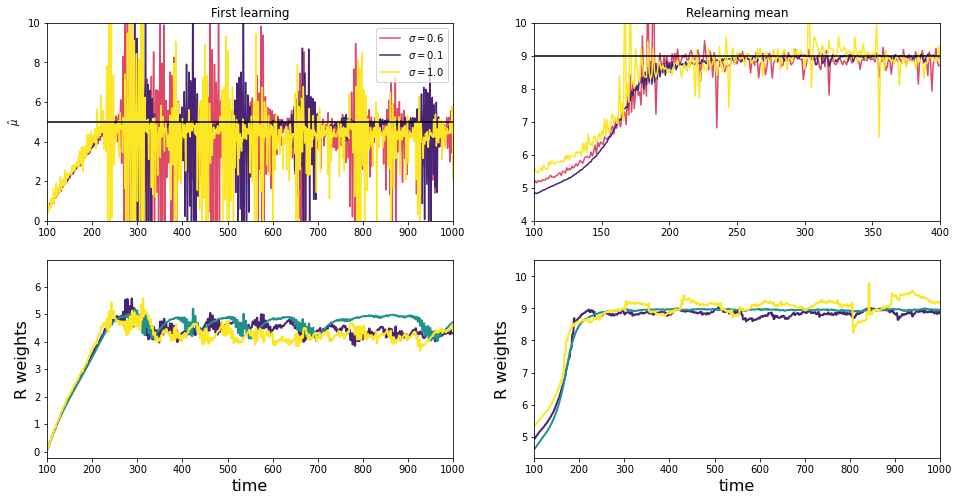

In [227]:
plt.figure(figsize=(16,8))
plt.title('relearning the mean')
plt.subplot(221)
plt.title('First learning')
plt.plot(results1r['rR'], color = cm.magma(0.6), label= r'$\sigma=0.6$')
plt.plot(results2r['rR'], color = cm.viridis(0.1),label=r'$\sigma=0.1$')
plt.plot(results4r['rR'], color = cm.viridis(1.0),label=r'$\sigma=1.0$')

plt.plot(np.ones(1000)*5,'k')
plt.xlim(100,1000)
plt.ylabel(r'$\hat{\mu}$')
plt.legend()

#plt.xlim(400,500)
#plt.ylim(6.0,12.0)
plt.ylim(0,10)
plt.subplot(222)
plt.title('Relearning mean')
plt.plot(results1_new['rR'], color = cm.magma(0.6), label = r'$\sigma=0.6$')
plt.plot(results2_new['rR'], color = cm.viridis(0.1), label=r'$\sigma=0.1$')
plt.plot(results4_new['rR'], color = cm.viridis(1.0), label=r'$\sigma=1.0$')
plt.plot(np.ones(1000)*9,'k')
plt.xlim(100,400)
plt.ylim(4,10)
#plt.xlim(300,400)
#plt.ylim(8.5,9.5)
plt.subplot(223)
plt.plot(results1r['wRX1'], label=r'$\sigma=0.6$', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wRX1'], label=r'$\sigma=0.1$',color =cm.viridis(.5),linewidth=2)
plt.plot(results4r['wRX1'], label=r'$\sigma=1.0$',color =cm.viridis(1.0),linewidth=2)

plt.ylabel('R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.xlim(100,1000)

plt.subplot(224)
plt.plot(results1_new['wRX1'], label=r'$\sigma=0.6$', color =cm.viridis(.1),linewidth=2)
plt.plot(results2_new['wRX1'], label=r'$\sigma=0.1$',color =cm.viridis(.5),linewidth=2)
plt.plot(results4_new['wRX1'], label=r'$\sigma=1.0$',color =cm.viridis(1.0),linewidth=2)

plt.ylabel('R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.xlim(100,1000)

#plt.title('no relearning')
#plt.plot(results3rp['rR'], color = cm.magma(0.6),label = 'no scaling')
#plt.plot(results3r['rR'], color = cm.viridis(0.4), label='uncertainty-scaled')
#plt.plot(np.ones(1000)*5,'k')
#plt.xlim(100,400)
#plt.ylim(0,10)

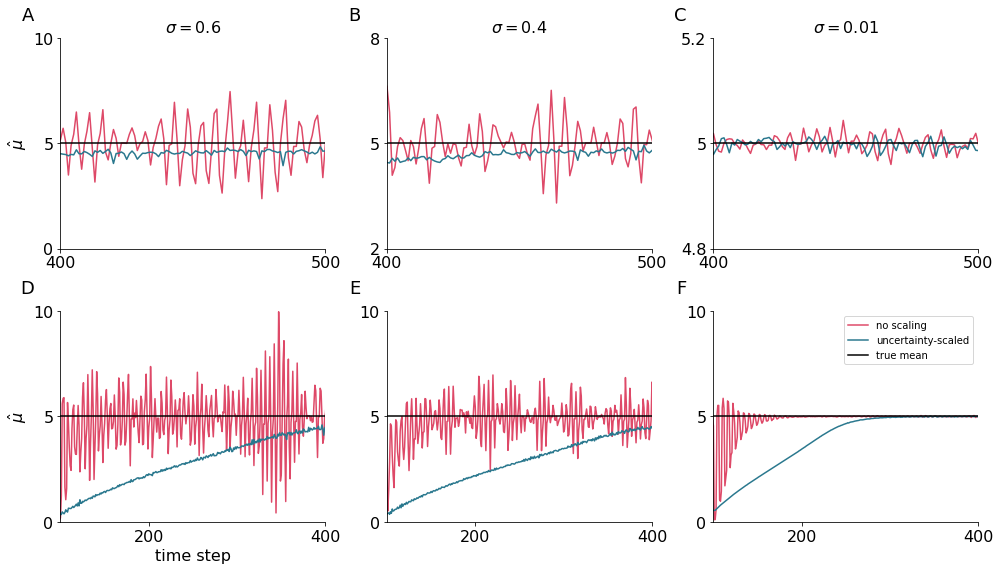

In [590]:
subplots_list = []
plt.figure(figsize=(14,8))

subplots_list.append(plt.subplot(231))
plt.title(r'$\sigma=0.6$',fontsize=16)

plt.plot(results1rp['rR'], color = cm.magma(0.6),label = 'no scaling')
plt.plot(results1r['rR'], color = cm.viridis(0.4),label='uncertainty-scaled')
plt.plot(np.ones(1000)*5,'k')
plt.ylabel(r'$\hat{\mu}$',fontsize=16)

plt.xlim(400,500)
plt.ylim(0,10)
plt.yticks([0,5,10],[0,5,10],fontsize=16)
plt.xticks([400,500],[400,500],fontsize=16)


subplots_list.append(plt.subplot(232))
plt.title(r'$\sigma=0.4$',fontsize=16)

plt.plot(results2rp['rR'], color = cm.magma(0.6),label = 'no scaling')
plt.plot(results2r['rR'], color = cm.viridis(0.4),label='uncertainty-scaled')
plt.plot(np.ones(1000)*5,'k')
plt.xlim(400,500)
plt.ylim(2,8)
plt.yticks([2,5,8],[2,5,8],fontsize=16)
plt.xticks([400,500],[400,500],fontsize=16)


subplots_list.append(plt.subplot(233))
plt.title(r'$\sigma=0.01$',fontsize=16)

plt.plot(results3rp['rR'], color = cm.magma(0.6),label = 'no scaling')
plt.plot(results3r['rR'], color = cm.viridis(0.4),label='uncertainty-scaled')
plt.plot(np.ones(1000)*5,'k')
plt.xlim(400,500)
plt.ylim(4.8,5.2)
plt.yticks([4.8,5,5.2],[4.8,5,5.2],fontsize=16)
plt.xticks([400,500],[400,500],fontsize=16)

subplots_list.append(plt.subplot(234))
plt.ylabel(r'$\hat{\mu}$',fontsize=16)
plt.plot(results1rp['rR'], color = cm.magma(0.6),label = 'no scaling')
plt.plot(results1r['rR'], color = cm.viridis(0.4),label='uncertainty-scaled')
plt.plot(np.ones(1000)*5,'k')
plt.xlim(100,400)
plt.ylim(0,10)
plt.yticks([0,5,10],[0,5,10],fontsize=16)
plt.xticks([200,400],[200,400],fontsize=16)
plt.xlabel('time step',fontsize=16)

subplots_list.append(plt.subplot(235))
plt.plot(results2rp['rR'], color = cm.magma(0.6),label = 'no scaling')
plt.plot(results2r['rR'], color = cm.viridis(0.4),label='uncertainty-scaled')
plt.plot(np.ones(1000)*5,'k')
plt.xlim(100,400)
plt.ylim(0,10)
plt.yticks([0,5,10],[0,5,10],fontsize=16)
plt.xticks([200,400],[200,400],fontsize=16)

subplots_list.append(plt.subplot(236)) 
plt.plot(results3rp['rR'], color = cm.magma(0.6),label = 'no scaling')
plt.plot(results3r['rR'], color = cm.viridis(0.4),label='uncertainty-scaled')
plt.plot(np.ones(1000)*5,'k', label='true mean')
plt.xlim(100,400)
plt.ylim(0,10)
plt.yticks([0,5,10],[0,5,10],fontsize=16)
plt.xticks([200,400],[200,400],fontsize=16)

plt.legend()



alph_label = ['A','B','C','D','E','F','G']
for i, sub in enumerate(subplots_list):
    sub.spines['top'].set_visible(False)
    sub.spines['right'].set_visible(False)
    sub.text(-0.1, 1.15, alph_label[i], transform=sub.transAxes,
          fontsize=18, va='top', ha='right')
plt.tight_layout()
#plt.savefig('./variability_of_the_mean_prediction.png', bbox_inches='tight',rasterized=True)


In [80]:
def plot_rate(results1,results2, name1, name2, pop1='rP_P',pop2='rP_N'):

    subplots_list = []
    plt.figure(figsize=(14,8))

    subplots_list.append(plt.subplot(121))
    #plt.title(r'$\sigma=0.6$',fontsize=16)

    plt.plot(results1[pop1], color = cm.magma(0.6),label =name1)
    plt.plot(results2[pop1], color = cm.viridis(0.4),label=name2)
    plt.ylabel(pop1,fontsize=16)
    plt.xlim(0,50)

    #plt.xlim(400,500)
    #plt.ylim(0,10)
    #plt.yticks([0,5,10],[0,5,10],fontsize=16)
    #plt.xticks([400,500],[400,500],fontsize=16)


    subplots_list.append(plt.subplot(122))
    #plt.title(r'$\sigma=0.4$',fontsize=16)

    plt.plot(results1[pop2], color = cm.magma(0.6),label =name1)
    plt.plot(results2[pop2], color = cm.viridis(0.4),label=name2)
    plt.ylabel(pop2,fontsize=16)
    plt.legend()
    #plt.xlim(400,500)
    plt.xlim(0,50)
    #plt.yticks([2,5,8],[2,5,8],fontsize=16)
    #plt.xticks([400,500],[400,500],fontsize=16)

In [222]:
def plot_results(results1, results2, name):
    plt.figure(figsize=(7.5,5.5))

    a1 = plt.subplot(241)
    a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
          fontsize=16, va='top', ha='right')
    plt.plot(results1['wRX1'], label='x1->R', color =cm.viridis(.1),linewidth=2)
    plt.plot(results2['wRX1'], label='x2->R',color =cm.viridis(.5),linewidth=2)
    plt.ylabel('R weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    plt.legend(loc='lower right')
    plt.xlim(0,1000)
    #plt.xticks([0,1000],[0,1000],fontsize=16)
    #plt.ylim(5.5,6.2)
    #plt.yticks([0,5],[0,5],fontsize=16)
    a1.spines['top'].set_visible(False)
    a1.spines['right'].set_visible(False)

    a5 = plt.subplot(242)
    a5.text(-0.1, 1.15, 'B', transform=a5.transAxes,
          fontsize=16, va='top', ha='right')
    plt.plot(results1['wPX1_P'], label='x1', color =cm.viridis(.1),linewidth=2)
    plt.plot(results2['wPX1_P'], label='x2',color =cm.viridis(.5),linewidth=2)
    plt.ylabel('PV+ weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    plt.yticks([0,1],[0,1],fontsize=16)
    plt.xticks([0,300000],[0,300000],fontsize=16)
    #plt.ylim(0,1.25)
    plt.xlim(0,310000)
    plt.xlim(0,7100)
    
    plt.legend(loc='lower right')
    a5.spines['top'].set_visible(False)
    a5.spines['right'].set_visible(False)

    a5 = plt.subplot(243)
    a5.text(-0.1, 1.15, 'B', transform=a5.transAxes,
          fontsize=16, va='top', ha='right')
    plt.plot(results1['wPX1_N'], label='x1', color =cm.viridis(.1),linewidth=2)
    plt.plot(results2['wPX1_N'], label='x2',color =cm.viridis(.5),linewidth=2)
    plt.ylabel('PV- weights',fontsize=16)
    plt.xlabel('time',fontsize=16)
    plt.yticks([0,1],[0,1],fontsize=16)
    #plt.xticks([0,300000],[0,300000],fontsize=16)
    #plt.xticks([0,300],[0,300],fontsize=16)

    #plt.ylim(0,1.25)
    plt.xlim(0,310000)
    plt.xlim(0,3100)
    
    plt.legend(loc='lower right')
    a5.spines['top'].set_visible(False)
    a5.spines['right'].set_visible(False)

    a3 = plt.subplot(244)
    a3.text(-0.1, 1.15, 'C', transform=a3.transAxes,
          fontsize=16, va='top', ha='right')
    plt.bar([0,1],[results1['SST_P_avg'],results2['SST_P_avg']],yerr=[results1['SST_P_std'],results2['SST_P_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
    plt.ylim(0,6)
    plt.xlim(-0.5,1.5)
    plt.yticks([0,5],[0,5],fontsize=16)
    a3.spines['top'].set_visible(False)
    a3.spines['right'].set_visible(False)
    plt.ylabel('SST+ rate',fontsize=16)
    plt.xticks([0,1],['high','low'],fontsize=16)
    plt.xlabel('uncertainty',fontsize=16)

    #plt.xticks([0,1],['x1','x2'],fontsize=16)

    a9 = plt.subplot(245)
    a9.text(-0.1, 1.15, 'E', transform=a9.transAxes,
          fontsize=16, va='top', ha='right')
    plt.bar([0,1],[results1['R_avg'],results2['R_avg']],yerr=[results1['R_std'],results2['R_std']],color=[cm.magma(.5),cm.viridis(.5)],width=0.3)  
    #plt.ylim(0,7)
    plt.xlim(-0.5,1.5)
    plt.yticks([0,5],[0,5],fontsize=16)
    a9.spines['top'].set_visible(False)
    a9.spines['right'].set_visible(False)
    plt.ylabel('R rate',fontsize=16)
    #plt.xticks([0,1],['x1','x2'],fontsize=16)
    plt.xticks([0,1],['high','low'],fontsize=16)
    plt.xlabel('uncertainty',fontsize=16)

    a2 = plt.subplot(246)
    a2.text(-0.1, 1.15, 'D', transform=a2.transAxes,
          fontsize=16, va='top', ha='right')
    plt.bar([0,1],[results1['PV_P_avg'],results2['PV_P_avg']],yerr=[results1['PV_P_std'],results2['PV_P_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
    plt.ylabel('PV+ rate',fontsize=16)
    #plt.xticks([0,1],['x1','x2'],fontsize=16)
    plt.xticks([0,1],['high','low'],fontsize=16)
    plt.xlabel('uncertainty',fontsize=16)

    plt.yticks([0,2],[0,2],fontsize=16)
    a2.spines['top'].set_visible(False)
    a2.spines['right'].set_visible(False)
    #plt.ylim(0,2.3)
    plt.xlim(-0.5,1.5)

    a2 = plt.subplot(247)
    a2.text(-0.1, 1.15, 'D', transform=a2.transAxes,
          fontsize=16, va='top', ha='right')
    plt.bar([0,1],[results1['PV_N_avg'],results2['PV_N_avg']],yerr=[results1['PV_N_std'],results2['PV_N_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
    plt.ylabel('PV- rate',fontsize=16)
    #plt.xticks([0,1],['x1','x2'],fontsize=16)
    plt.xticks([0,1],['high','low'],fontsize=16)
    plt.xlabel('uncertainty',fontsize=16)

    #plt.yticks([0,2],[0,2],fontsize=16)
    a2.spines['top'].set_visible(False)
    a2.spines['right'].set_visible(False)
    #plt.ylim(0,2.3)
    plt.xlim(-0.5,1.5)


    a9 = plt.subplot(248)
    a9.text(-0.1, 1.15, 'E', transform=a9.transAxes,
          fontsize=16, va='top', ha='right')
    plt.bar([0,1],[results1['SST_N_avg'],results2['SST_N_avg']],yerr=[results1['SST_N_std'],results2['SST_N_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
    #plt.ylim(0,7)
    plt.xlim(-0.5,1.5)
    #plt.yticks([0,5],[0,5],fontsize=16)
    a9.spines['top'].set_visible(False)
    a9.spines['right'].set_visible(False)
    plt.ylabel('SST- rate',fontsize=16)
    #plt.xticks([0,1],['x1','x2'],fontsize=16)
    plt.xticks([0,1],['high','low'],fontsize=16)
    plt.xlabel('uncertainty',fontsize=16)

    plt.tight_layout()
    plt.savefig('./results_%s.png'%name, bbox_inches='tight',rasterized=True)


<ipython-input-222-fbc78b605ea4>:130: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_%s.png'%name, bbox_inches='tight',rasterized=True)
<ipython-input-222-fbc78b605ea4>:130: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_%s.png'%name, bbox_inches='tight',rasterized=True)
<ipython-input-222-fbc78b605ea4>:130: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_%s.png'%name, bbox_inches='tight',rasterized=True)
<ipython-input-222-fbc78b605ea4>:130: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no l

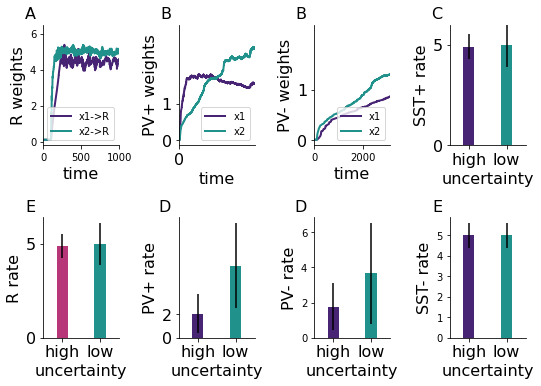

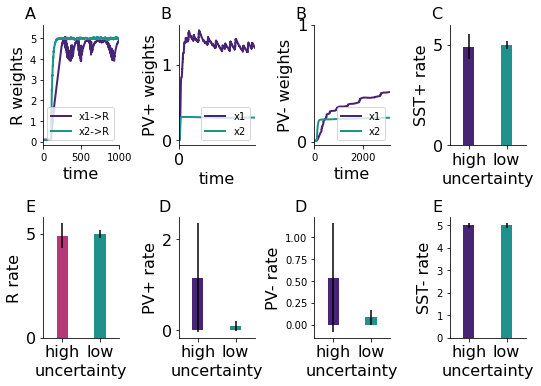

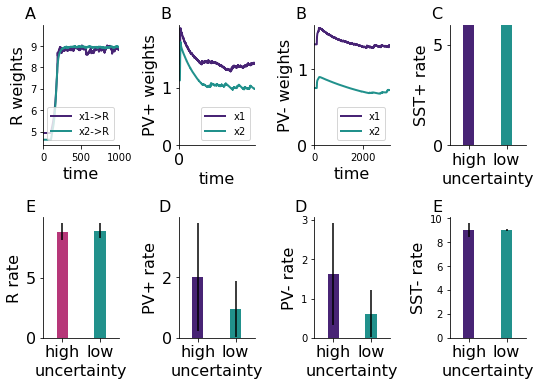

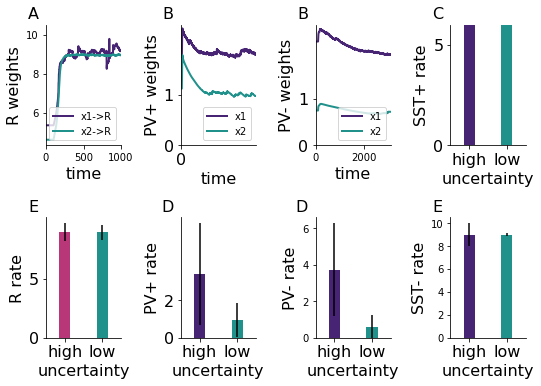

In [236]:
#plt.plot_results(results1n, results2n, 'non_rectified')
plot_results(results1r, results1rp, 'rectified_withPVinit1')
plot_results(results2r, results2rp, 'pathological_rectified')
#plot_results(results3r, results3rp, 'pathological_rectified_lowvariance')
plot_results(results1_new, results2_new, 'new_mean')
plot_results(results4_new, results2_new, 'new_mean')


<ipython-input-96-9b44b68fc2b6>:130: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_%s.png'%name, bbox_inches='tight',rasterized=True)
<ipython-input-96-9b44b68fc2b6>:130: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_%s.png'%name, bbox_inches='tight',rasterized=True)


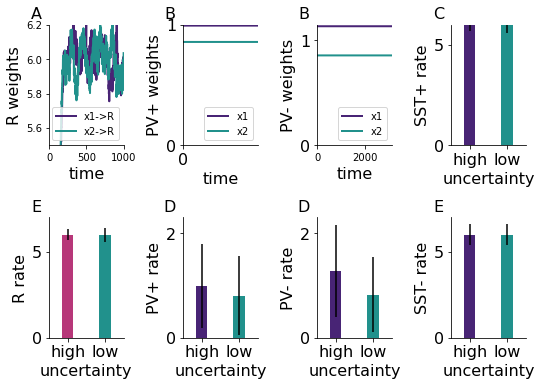

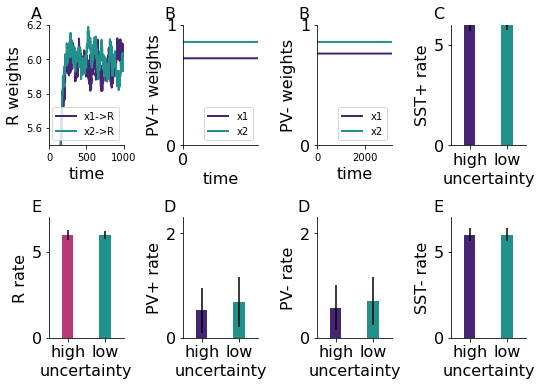

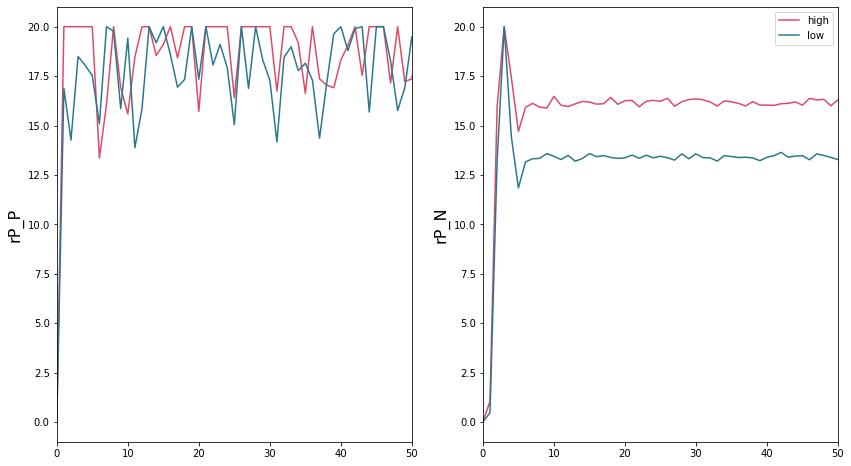

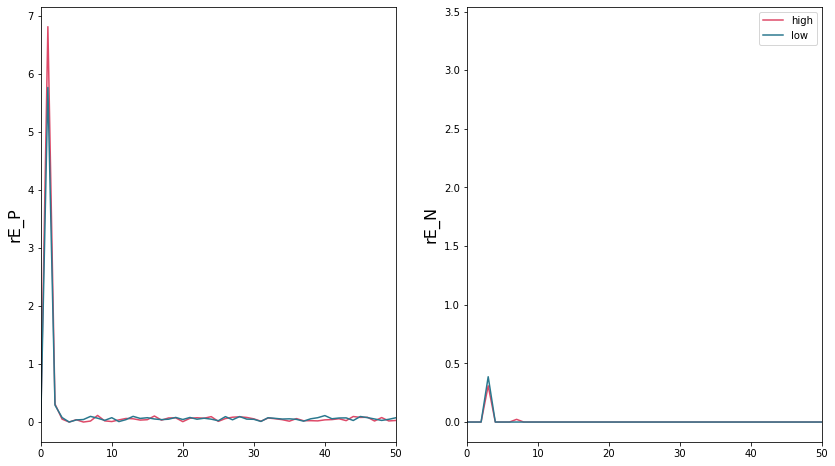

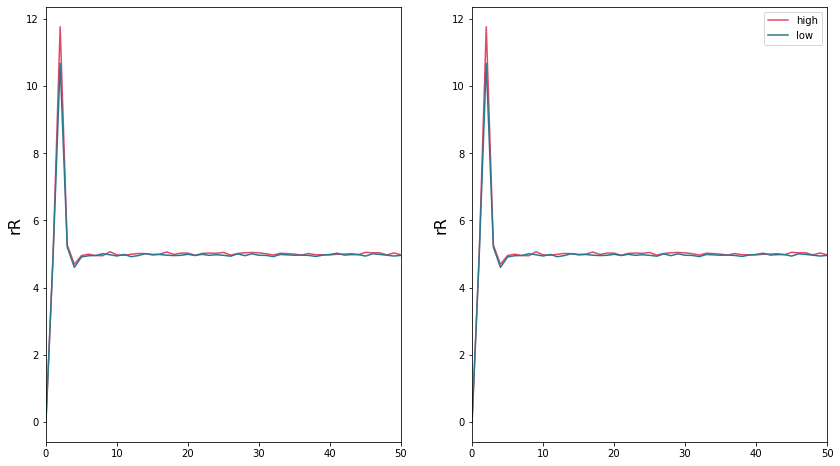

In [97]:
#plt.plot_results(results1n, results2n, 'non_rectified')
plot_results(results1fix_new, results1fixp_new, 'new')
plot_results(results2fix_new, results2fixp_new, 'new')

#plot_results(results1rp, results2rp, 'pathological_rectified')
#plot_results(results3r, results3rp, 'pathological_rectified_lowvariance')
#plot_results(results2fix_new, results2fixp_new, 'new_patho')
plot_rate(results1fix_new,results2fix_new, 'high', 'low','rP_P','rP_N')
plot_rate(results1fix_new,results2fix_new, 'high', 'low','rE_P','rE_N')
plot_rate(results1fix_new,results2fix_new, 'high', 'low','rR','rR')

In [46]:
1/2*(results1r['PV_P_avg']+results2r['PV_P_avg'])

0.8041426954510522

In [47]:
1/2*(results1fix_new['PV_P_avg']+results2fix_new['PV_P_avg'])

0.7518192275563846

In [48]:
print(results1fix_new['PV_P_avg'])
print(results2fix_new['PV_P_avg'])

0.984475592641572
0.5191628624711971


In [21]:
a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1r['wPS_P'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wPS_P'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('SST+ to PV+ weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
plt.xlim(0,1000)
#plt.xticks([0,1000],[0,1000],fontsize=16)
#plt.ylim(0,6)
#plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

NameError: name 'a1' is not defined

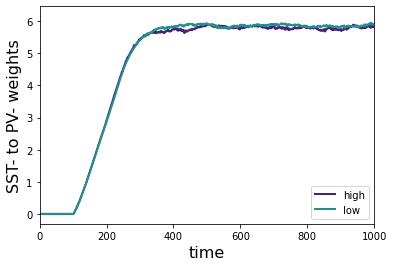

In [455]:
a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1r['wPS_N'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wPS_N'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('SST- to PV- weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
plt.xlim(0,1000)
#plt.xticks([0,1000],[0,1000],fontsize=16)
#plt.ylim(0,6)
#plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

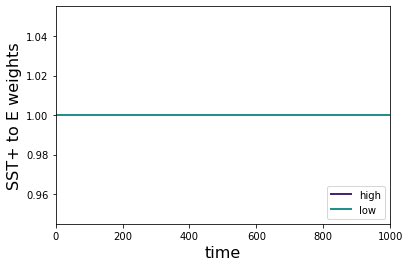

In [456]:
a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1['wES_P'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wES_P'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('SST+ to E weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
plt.xlim(0,1000)
#plt.xticks([0,1000],[0,1000],fontsize=16)
#plt.ylim(0,6)
#plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

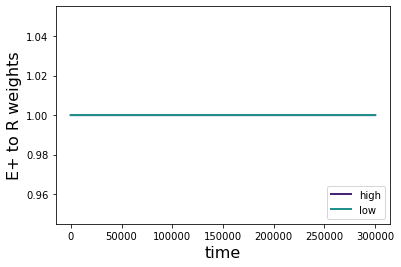

In [457]:
a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1['wRE_P'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wRE_P'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('E+ to R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
#plt.xlim(0,1000)
#plt.xticks([0,1000],[0,1000],fontsize=16)
#plt.ylim(0,6)
#plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

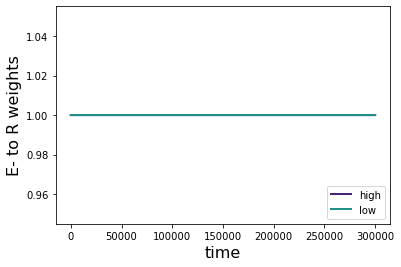

In [458]:
a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1['wRE_N'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wRE_N'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('E- to R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
#plt.xlim(0,1000)
#plt.xticks([0,1000],[0,1000],fontsize=16)
#plt.ylim(0,6)
#plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

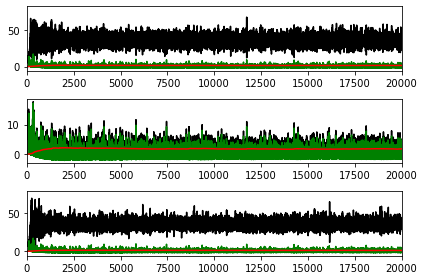

In [459]:
#plt.plot(results1['PV_in_target'], color = 'k', label = 'target')
plt.figure()
plt.subplot(311)
plt.plot(results1['PV_in_target']**2, color = 'k', label = 'target')
plt.plot(results1['PV_deltaw'], color = 'g')

plt.plot(results1['PV_in_wX']**2, color = 'r', label = 'wX')
#plt.ylim(-0.5,2)
#plt.xlim(10300,10500)
plt.xlim(0,20000)

plt.subplot(312)
#plt.plot(results1['PV_in_target'], color = 'k', label = 'target')
plt.plot(results1['rP_P'], color = 'k', label = 'target')
plt.plot(results1['PV_deltaw'], color = 'g')

plt.plot(results1['PV_in'], color = 'r', label = 'wX')
#plt.ylim(-0.5,2)
plt.xlim(0,20000)
plt.subplot(313)

plt.plot(results2['PV_in_target']**2, color = 'k', label = 'target')
plt.plot(results1['PV_deltaw'], color = 'g')

plt.plot(results2['PV_in_wX']**2, color = 'r', label = 'wX')
#plt.ylim(-0.5,2)
#plt.xlim(10300,10500)
plt.xlim(0,20000)
plt.tight_layout()
#plt.savefig('./weightchanges_rectified.pdf', bbox_inches='tight',rasterized=True)


<ipython-input-460-91170a08226e>:153: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_fullcircuit_nonrectified_allplastic.png', bbox_inches='tight',rasterized=True)


"\na10 = plt.subplot(338)\nplt.plot(rP1, color = 'k')#,\n         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))\nplt.ylabel('PV rate 1',fontsize=16)\nplt.xlabel('time',fontsize=16)\nplt.ylim(0,10)\n\na10 = plt.subplot(339)\nplt.plot(rP2, color = 'k')#,\n         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))\nplt.ylabel('PV rate 2',fontsize=16)\nplt.xlabel('time',fontsize=16)\nplt.ylim(0,10)\n"

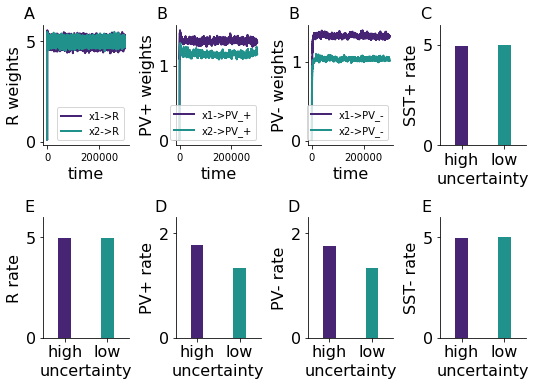

In [460]:
plt.figure(figsize=(7.5,5.5))
"""
a0 = plt.subplot(331)
plt.plot(rY1,'.',color =cm.viridis(.1))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.1), linestyle='-',linewidth=20)

#plt.plot(rY2,'.',color =cm.viridis(.5))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
plt.ylabel('whisker deflecton t',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)
plt.ylim(0,8)
plt.xlim(0,100)
plt.xticks([0,100],[0,100],fontsize=16)

#plt.legend(loc='lower right')
a6 = plt.subplot(332)
#plt.plot(rY1,'.',color =cm.viridis(.3))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
plt.plot(rY2,'.',color =cm.viridis(.5))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.5), linestyle='-',linewidth=20)

plt.ylabel('whisker deflecction t',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,8)
plt.xlim(0,100)
plt.yticks([0,5],[0,5],fontsize=16)
plt.xticks([0,100],[0,100],fontsize=16)
a6.spines['top'].set_visible(False)
a6.spines['right'].set_visible(False)
"""

a1 = plt.subplot(241)
a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1['wRX1'], label='x1->R', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wRX1'], label='x2->R',color =cm.viridis(.5),linewidth=2)
plt.ylabel('R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
#plt.xlim(0,1000)
#plt.xticks([0,1000],[0,1000],fontsize=16)
#plt.ylim(0,6)
plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

a5 = plt.subplot(242)
a5.text(-0.1, 1.15, 'B', transform=a5.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1['wPX1_P'], label='x1->PV_+', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wPX1_P'], label='x2->PV_+',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV+ weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,100000],[0,100000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,110000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)

a5 = plt.subplot(243)
a5.text(-0.1, 1.15, 'B', transform=a5.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1['wPX1_N'], label='x1->PV_-', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wPX1_N'], label='x2->PV_-',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV- weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,100000],[0,100000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,110000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)

a3 = plt.subplot(244)
a3.text(-0.1, 1.15, 'C', transform=a3.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1['SST_P_avg'],results2['SST_P_avg']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST+ rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

#plt.xticks([0,1],['x1','x2'],fontsize=16)

a9 = plt.subplot(245)
a9.text(-0.1, 1.15, 'E', transform=a9.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1['R_avg'],results2['R_avg']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a9.spines['top'].set_visible(False)
a9.spines['right'].set_visible(False)
plt.ylabel('R rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

a2 = plt.subplot(246)
a2.text(-0.1, 1.15, 'D', transform=a2.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1['PV_P_avg'],results2['PV_P_avg']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
plt.ylabel('PV+ rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

plt.yticks([0,2],[0,2],fontsize=16)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
plt.ylim(0,2.3)
plt.xlim(-0.5,1.5)

a2 = plt.subplot(247)
a2.text(-0.1, 1.15, 'D', transform=a2.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1['PV_N_avg'],results2['PV_P_avg']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
plt.ylabel('PV- rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

plt.yticks([0,2],[0,2],fontsize=16)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
plt.ylim(0,2.3)
plt.xlim(-0.5,1.5)


a9 = plt.subplot(248)
a9.text(-0.1, 1.15, 'E', transform=a9.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1['SST_N_avg'],results2['SST_N_avg']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a9.spines['top'].set_visible(False)
a9.spines['right'].set_visible(False)
plt.ylabel('SST- rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

plt.tight_layout()
plt.savefig('./results_fullcircuit_nonrectified_allplastic.png', bbox_inches='tight',rasterized=True)

"""
a10 = plt.subplot(338)
plt.plot(rP1, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)

a10 = plt.subplot(339)
plt.plot(rP2, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
"""


<ipython-input-467-b92c4427e246>:153: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_fullcircuit_rect_allplastic.png', bbox_inches='tight',rasterized=True)


"\na10 = plt.subplot(338)\nplt.plot(rP1, color = 'k')#,\n         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))\nplt.ylabel('PV rate 1',fontsize=16)\nplt.xlabel('time',fontsize=16)\nplt.ylim(0,10)\n\na10 = plt.subplot(339)\nplt.plot(rP2, color = 'k')#,\n         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))\nplt.ylabel('PV rate 2',fontsize=16)\nplt.xlabel('time',fontsize=16)\nplt.ylim(0,10)\n"

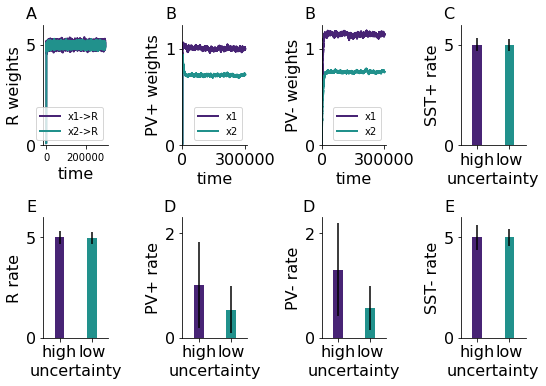

In [467]:
plt.figure(figsize=(7.5,5.5))
"""
a0 = plt.subplot(331)
plt.plot(rY1,'.',color =cm.viridis(.1))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.1), linestyle='-',linewidth=20)

#plt.plot(rY2,'.',color =cm.viridis(.5))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
plt.ylabel('whisker deflecton t',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)
plt.ylim(0,8)
plt.xlim(0,100)
plt.xticks([0,100],[0,100],fontsize=16)

#plt.legend(loc='lower right')
a6 = plt.subplot(332)
#plt.plot(rY1,'.',color =cm.viridis(.3))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
plt.plot(rY2,'.',color =cm.viridis(.5))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.5), linestyle='-',linewidth=20)

plt.ylabel('whisker deflecction t',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,8)
plt.xlim(0,100)
plt.yticks([0,5],[0,5],fontsize=16)
plt.xticks([0,100],[0,100],fontsize=16)
a6.spines['top'].set_visible(False)
a6.spines['right'].set_visible(False)
"""

a1 = plt.subplot(241)
a1.text(-0.1, 1.15, 'A', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1r['wRX1'], label='x1->R', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wRX1'], label='x2->R',color =cm.viridis(.5),linewidth=2)
plt.ylabel('R weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.legend(loc='lower right')
#plt.xlim(0,1000)
#plt.xticks([0,1000],[0,1000],fontsize=16)
plt.ylim(0,6)
plt.yticks([0,5],[0,5],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

a5 = plt.subplot(242)
a5.text(-0.1, 1.15, 'B', transform=a5.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1r['wPX1_P'], label='x1', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wPX1_P'], label='x2',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV+ weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,1],[0,1],fontsize=16)
plt.xticks([0,300000],[0,300000],fontsize=16)
plt.ylim(0,1.25)
plt.xlim(0,310000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)

a5 = plt.subplot(243)
a5.text(-0.1, 1.15, 'B', transform=a5.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(results1r['wPX1_N'], label='x1', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wPX1_N'], label='x2',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV- weights',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,1],[0,1],fontsize=16)
plt.xticks([0,300000],[0,300000],fontsize=16)
plt.ylim(0,1.25)
plt.xlim(0,310000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)

a3 = plt.subplot(244)
a3.text(-0.1, 1.15, 'C', transform=a3.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1r['SST_P_avg'],results2r['SST_P_avg']],yerr=[results1r['SST_P_std'],results2r['SST_P_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST+ rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

#plt.xticks([0,1],['x1','x2'],fontsize=16)

a9 = plt.subplot(245)
a9.text(-0.1, 1.15, 'E', transform=a9.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1r['R_avg'],results2r['R_avg']],yerr=[results1r['R_std'],results2r['R_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a9.spines['top'].set_visible(False)
a9.spines['right'].set_visible(False)
plt.ylabel('R rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

a2 = plt.subplot(246)
a2.text(-0.1, 1.15, 'D', transform=a2.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1r['PV_P_avg'],results2r['PV_P_avg']],yerr=[results1r['PV_P_std'],results2r['PV_P_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
plt.ylabel('PV+ rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

plt.yticks([0,2],[0,2],fontsize=16)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
plt.ylim(0,2.3)
plt.xlim(-0.5,1.5)

a2 = plt.subplot(247)
a2.text(-0.1, 1.15, 'D', transform=a2.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1r['PV_N_avg'],results2r['PV_N_avg']],yerr=[results1r['PV_N_std'],results2r['PV_N_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)
plt.ylabel('PV- rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

plt.yticks([0,2],[0,2],fontsize=16)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
plt.ylim(0,2.3)
plt.xlim(-0.5,1.5)


a9 = plt.subplot(248)
a9.text(-0.1, 1.15, 'E', transform=a9.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[results1r['SST_N_avg'],results2r['SST_N_avg']],yerr=[results1r['SST_N_std'],results2r['SST_N_std']],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a9.spines['top'].set_visible(False)
a9.spines['right'].set_visible(False)
plt.ylabel('SST- rate',fontsize=16)
#plt.xticks([0,1],['x1','x2'],fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

plt.tight_layout()
plt.savefig('./results_fullcircuit_rect_allplastic.png', bbox_inches='tight',rasterized=True)

"""
a10 = plt.subplot(338)
plt.plot(rP1, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)

a10 = plt.subplot(339)
plt.plot(rP2, color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
"""


<ipython-input-462-eb978c7b4a76>:181: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_rectifiedtopbottomall_sigma0406.pdf', bbox_inches='tight',rasterized=True)


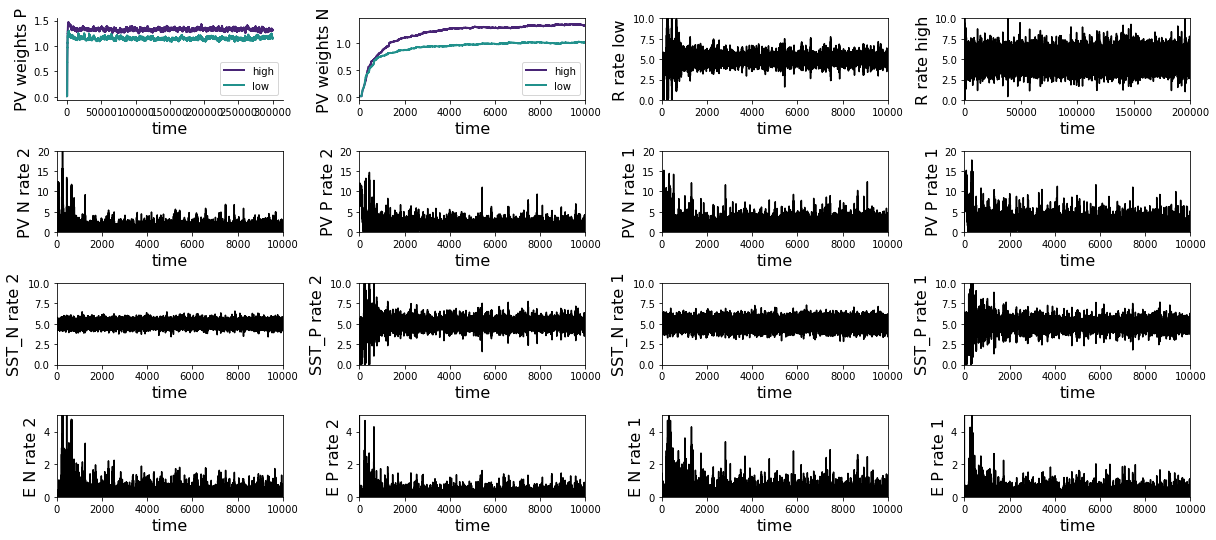

In [462]:
plt.figure(figsize=(17,7.5))

a5 = plt.subplot(441)
plt.plot(results1['wPX1_P'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wPX1_P'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights P',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)


a3 = plt.subplot(442)
plt.plot(results1['wPX1_N'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2['wPX1_N'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights N',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)
plt.xlim(0,10000)


a11 = plt.subplot(4,4,3)
plt.plot(results2['rR'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('R rate low',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.xlim(0,10000)
plt.ylim(0,10)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,4)
plt.plot(results1['rR'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('R rate high',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.xlim(0,10000)
plt.ylim(0,10)
plt.xlim(0,200000)


a0 = plt.subplot(445)
plt.plot(results2['rP_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV N rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)


#plt.legend(loc='lower right')
a6 = plt.subplot(446)

plt.plot(results2['rP_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV P rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,7)
plt.plot(results1['rP_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV N rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,8)
plt.plot(results1['rP_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV P rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)





"""plt.bar([0,1],[SST_avg2,SSTp_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)
"""

a2 = plt.subplot(449)
plt.plot(results2['rS_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_N rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)


a9 = plt.subplot(4,4,10)
plt.plot(results2['rS_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_P rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)


a2 = plt.subplot(4,4,11)
plt.plot(results1['rS_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_N rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)


a9 = plt.subplot(4,4,12)
plt.plot(results1['rS_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_P rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)



a10 = plt.subplot(4,4,13)
plt.plot(results2['rE_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E N rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)

a10 = plt.subplot(4,4,14)
plt.plot(results2['rE_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E P rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,15)
plt.plot(results1['rE_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E N rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)

a10 = plt.subplot(4,4,16)
plt.plot(results1['rE_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E P rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)








plt.tight_layout()
plt.savefig('./results_rectifiedtopbottomall_sigma0406.pdf', bbox_inches='tight',rasterized=True)


<ipython-input-463-6c5592949c9e>:181: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./results_rectifiedtopbottomall_sigma0406.pdf', bbox_inches='tight',rasterized=True)


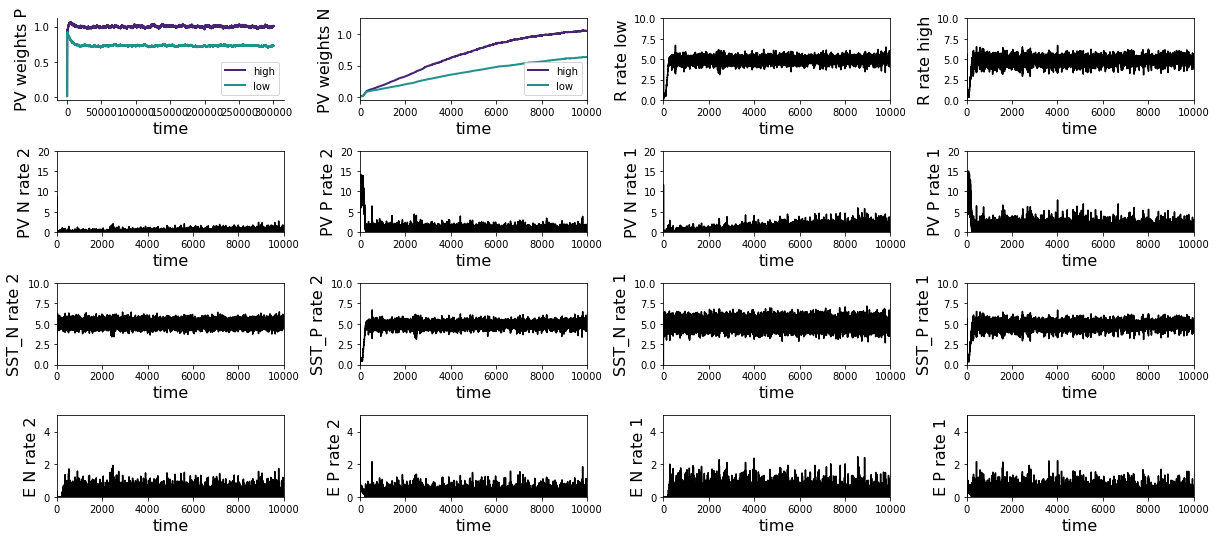

In [463]:
plt.figure(figsize=(17,7.5))

a5 = plt.subplot(441)
plt.plot(results1r['wPX1_P'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wPX1_P'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights P',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)


a3 = plt.subplot(442)
plt.plot(results1r['wPX1_N'], label='high', color =cm.viridis(.1),linewidth=2)
plt.plot(results2r['wPX1_N'], label='low',color =cm.viridis(.5),linewidth=2)
plt.ylabel('PV weights N',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.yticks([0,1],[0,1],fontsize=16)
#plt.xticks([0,10000],[0,10000],fontsize=16)
#plt.ylim(0,1.25)
#plt.xlim(0,11000)
plt.legend(loc='lower right')
a5.spines['top'].set_visible(False)
a5.spines['right'].set_visible(False)
plt.xlim(0,10000)


a11 = plt.subplot(4,4,3)
plt.plot(results2r['rR'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('R rate low',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.xlim(0,10000)
plt.ylim(0,10)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,4)
plt.plot(results1r['rR'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('R rate high',fontsize=16)
plt.xlabel('time',fontsize=16)
#plt.xlim(0,10000)
plt.ylim(0,10)
plt.xlim(0,10000)


a0 = plt.subplot(445)
plt.plot(results2r['rP_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV N rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)


#plt.legend(loc='lower right')
a6 = plt.subplot(446)

plt.plot(results2r['rP_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV P rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,7)
plt.plot(results1r['rP_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV N rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,8)
plt.plot(results1r['rP_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('PV P rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,20)
plt.xlim(0,10000)





"""plt.bar([0,1],[SST_avg2,SSTp_avg2],color=[cm.viridis(.1),cm.viridis(.5)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST rate',fontsize=16)
plt.xticks([0,1],['x1','x2'],fontsize=16)
"""

a2 = plt.subplot(449)
plt.plot(results2r['rS_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_N rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)


a9 = plt.subplot(4,4,10)
plt.plot(results2r['rS_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_P rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)


a2 = plt.subplot(4,4,11)
plt.plot(results1r['rS_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_N rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)


a9 = plt.subplot(4,4,12)
plt.plot(results1r['rS_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('SST_P rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,10)
plt.xlim(0,10000)



a10 = plt.subplot(4,4,13)
plt.plot(results2r['rE_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E N rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)

a10 = plt.subplot(4,4,14)
plt.plot(results2r['rE_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E P rate 2',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)


a10 = plt.subplot(4,4,15)
plt.plot(results1r['rE_N'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E N rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)

a10 = plt.subplot(4,4,16)
plt.plot(results1r['rE_P'], color = 'k')#,
         #label = 'mean rate during Y1: %.2f; Y2: %.2f'%(np.mean(rP_monitor[100:int(T/2)]),np.mean(rP_monitor[int(T/2)+100:])))
plt.ylabel('E P rate 1',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,5)
plt.xlim(0,10000)








plt.tight_layout()
plt.savefig('./results_rectifiedtopbottomall_sigma0406.pdf', bbox_inches='tight',rasterized=True)


In [430]:
def get_sum(c, windowsize=100):
    return np.add.reduceat(c, np.arange(0, len(c), windowsize))

<ipython-input-431-8ccfda2bae2a>:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./errorsum_rectified.pdf', bbox_inches='tight',rasterized=True)


NameError: name 'EP_sum3' is not defined

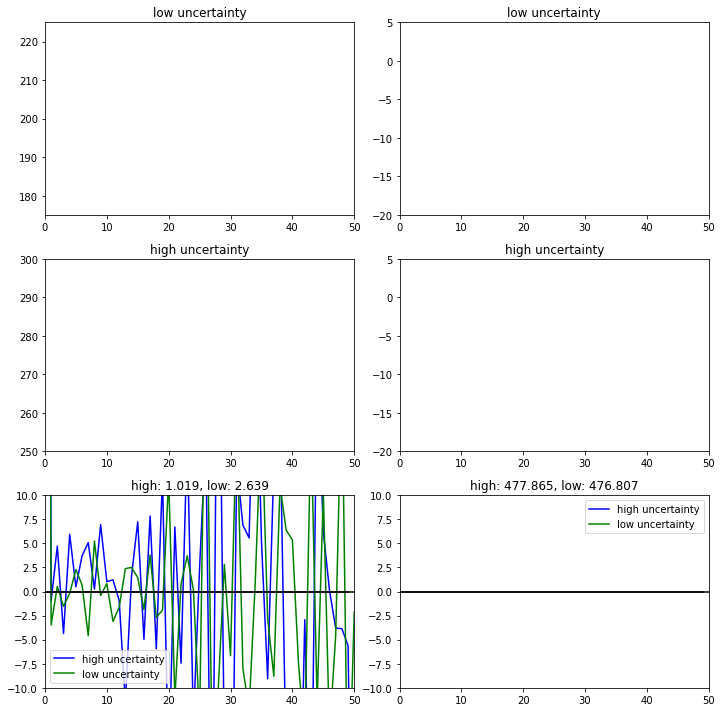

In [431]:
lower= 0
upper = 50
top = 5
bottom = -20
ws=1000
EP_sum1 = get_sum(results1['rE_P'],windowsize=ws)
EP_sum2 = get_sum(results2['rE_P'],windowsize=ws)
EN_sum1 = get_sum(results1['rE_N'],windowsize=ws)
EN_sum2 = get_sum(results2['rE_N'],windowsize=ws)
EP_sum1r = get_sum(results1r['rE_P'],windowsize=ws)
EP_sum2r = get_sum(results2r['rE_P'],windowsize=ws)
EN_sum1r = get_sum(results1r['rE_N'],windowsize=ws)
EN_sum2r = get_sum(results2r['rE_N'],windowsize=ws)
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title('low uncertainty')

plt.plot(EP_sum2, color='k')
plt.plot(EN_sum2, color='r')
plt.xlim(lower,upper)
plt.ylim(175,225)

plt.subplot(322)
plt.title('low uncertainty')
plt.plot(EP_sum2r, color='k')
plt.plot(EN_sum2r, color='r')
plt.xlim(lower,upper)
plt.ylim(bottom,top)

plt.subplot(323)
plt.title('high uncertainty')
plt.plot(EN_sum1,color='r')
plt.plot(EP_sum1, color='k')
plt.xlim(lower,upper)
#plt.ylim(-100,100)
#plt.ylim(bottom,top)
plt.ylim(250,300)


plt.subplot(325)
plt.plot(EP_sum1-EN_sum1,color='b',label='high uncertainty')
plt.plot(EP_sum2-EN_sum2, color='g',label='low uncertainty')
plt.plot(np.zeros(upper-lower),color='k')
plt.xlim(lower,upper)
plt.title('high: %.3f, low: %.3f'%(np.mean(EP_sum1[20:]-EN_sum1[20:]),np.mean(EP_sum2[20:]-EN_sum2[20:])))

plt.plot(np.zeros(1000),color='k')

plt.legend()
plt.ylim(-10,10)


plt.subplot(324)
plt.title('high uncertainty')
plt.plot(EN_sum1r,color='r')
plt.plot(EP_sum1r, color='k')
plt.xlim(lower,upper)
#plt.ylim(-100,100)
plt.ylim(bottom,top)


plt.subplot(326)
plt.plot(EP_sum1r-EN_sum1r,color='b',label='high uncertainty')
plt.plot(EP_sum2r-EN_sum2r, color='g',label='low uncertainty')
plt.plot(np.zeros(upper-lower),color='k')
plt.xlim(lower,upper)
plt.ylim(-10,10)
plt.title('high: %.3f, low: %.3f'%(np.mean(EP_sum1r[20:]-EN_sum1r[20:]),np.mean(EP_sum2r[20:]-EN_sum2r[20:])))
plt.plot(np.zeros(1000),color='k')


plt.legend()





plt.tight_layout()
plt.savefig('./errorsum_rectified.pdf', bbox_inches='tight',rasterized=True)
print(np.mean(EP_sum3-EN_sum3))

In [ ]:
Y1_mean_new = 7.0
Y2_mean_new = 7.0
Y1_sigma_new = 0.5
Y2_sigma_new = 0.5
E_avg1_new, PV_avg1_new, SST_avg1_new, R_avg1_new, dummy, dummy, rE1_new, rS1_new, rP1_new, rY1_new = run_network(mean= Y1_mean_new,sigma=Y1_sigma_new, w_init_PV = wPX1_monitor[-1], w_init_R = wRX1_monitor[-1], plastic=False)
E_avg2_new, PV_avg2_new, SST_avg2_new, R_avg2_new, dummy, dummy, rE2_new, rS2_new, rP2_new, rY2_new = run_network(mean= Y2_mean_new,sigma=Y2_sigma_new, w_init_PV = wPX2_monitor[-1], w_init_R = wRX2_monitor[-1], plastic=False)

In [ ]:
E_avg1_new


In [ ]:
x_values = np.arange(0, 10, 0.001)
y1_values = stats.norm(Y1_mean, Y1_sigma)
y2_values = stats.norm(Y2_mean, Y2_sigma)

plt.figure(figsize=(9.5,5.5))

aa = plt.subplot(241)
aa.text(-0.1, 1.15, 'A', transform=aa.transAxes,
      fontsize=16, va='top', ha='right')
aa.spines['top'].set_visible(False)
aa.spines['right'].set_visible(False)
aa.spines['bottom'].set_visible(False)
aa.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

#a = plt.subplot(241)
a = plt.subplot(242)
a.text(-0.1, 1.15, 'B', transform=a.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(x_values, y2_values.pdf(x_values), color = cm.viridis(0.1),linewidth =3,label='low uncertainty')
plt.plot(x_values, y1_values.pdf(x_values), color = cm.viridis(0.5),linewidth =3,label='high uncertainty')
plt.plot(np.ones((100))*3,np.arange(0,1,0.01),color = 'k',linewidth=3, label = 'mismatch')
ldg = plt.legend()
plt.xlim(0,10)
plt.ylim(0,2)
plt.yticks([0,1],[0,1],fontsize=16)
plt.xticks([5],[5],fontsize=16)
plt.xlabel('stimulus', fontsize = 16)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
#a.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=False)
a.legend(loc='upper left',markerscale=0.5,handlelength=1.0)#, bbox_to_anchor=(1, 0.5))


#plt.legend(loc='lower right')
a6 = plt.subplot(243)
a6.text(-0.1, 1.15, 'C', transform=a6.transAxes,
      fontsize=16, va='top', ha='right')
#plt.plot(rY1,'.',color =cm.viridis(.3))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
plt.plot(rY2,'.',color =cm.viridis(.1))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.5), linestyle='-',linewidth=20)

plt.ylabel('stimulus',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylim(0,8)
plt.xlim(0,100)
plt.yticks([0,5],[0,5],fontsize=16)
plt.xticks([0,100],[0,100],fontsize=16)
a6.spines['top'].set_visible(False)
a6.spines['right'].set_visible(False)


a0 = plt.subplot(244)
a0.text(-0.1, 1.15, 'D', transform=a0.transAxes,
      fontsize=16, va='top', ha='right')
plt.plot(rY1,'.',color =cm.viridis(.5))#, label='Y1: mean: %.1f, sigma: %.1f'%(Y1_mean,Y1_sigma))
#plt.axhline(y=0.1, color=cm.viridis(.1), linestyle='-',linewidth=20)

#plt.plot(rY2,'.',color =cm.viridis(.5))#, label='Y2: mean: %.1f, sigma: %.1f'%(Y2_mean,Y2_sigma))
plt.ylabel('stimulus',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)
plt.ylim(0,8)
plt.xlim(0,100)
plt.xticks([0,100],[0,100],fontsize=16)

"""a7 = plt.subplot(255)
a7.text(-0.1, 1.15, 'E', transform=a7.transAxes,
      fontsize=16, va='top', ha='right')
plt.errorbar(mean_range,SST_rates_mean, yerr=SST_std_mean, color = 'k', fmt='.')

plt.xlabel(r'$\mu$',fontsize=15)
plt.ylabel('SST rate',fontsize=15)
plt.xticks([0,5],[0,5],fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
plt.ylim(-0.2,6)
a7.spines['top'].set_visible(False)
a7.spines['right'].set_visible(False)
"""
ae = plt.subplot(245)
ae.spines['top'].set_visible(False)
ae.spines['right'].set_visible(False)
ae.spines['bottom'].set_visible(False)
ae.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

a1 = plt.subplot(246)
a1.text(-0.1, 1.15, 'F', transform=a1.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[E_avg1_new,E_avg2_new],color=[cm.viridis(.5),cm.viridis(.1)],width=0.3)  
plt.ylabel('E rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.yticks([0,1],[0,1],fontsize=16)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
plt.ylim(0,1.15)
plt.xlim(-0.5,1.5)
plt.xlabel('uncertainty',fontsize=16)


a2 = plt.subplot(247)
a2.text(-0.1, 1.15, 'G', transform=a2.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[PV_avg1_new,PV_avg2_new],color=[cm.viridis(.5),cm.viridis(.1)],width=0.3)  
plt.ylabel('PV rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.yticks([0,5],[0,5],fontsize=16)
plt.ylim(0,6)
a2.spines['top'].set_visible(False)
a2.spines['right'].set_visible(False)
plt.xlim(-0.5,1.5)
plt.xlabel('uncertainty',fontsize=16)


a3 = plt.subplot(248)
a3.text(-0.1, 1.15, 'H', transform=a3.transAxes,
      fontsize=16, va='top', ha='right')
plt.bar([0,1],[SST_avg1_new,SST_avg2_new],color=[cm.viridis(.5),cm.viridis(.1)],width=0.3)  
plt.ylim(0,6)
plt.xlim(-0.5,1.5)
plt.yticks([0,5],[0,5],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
plt.ylabel('SST rate',fontsize=16)
plt.xticks([0,1],['high','low'],fontsize=16)
plt.xlabel('uncertainty',fontsize=16)

"""
a3 = plt.subplot(2,5,10)
a3.text(-0.1, 1.15, 'I', transform=a3.transAxes,
      fontsize=16, va='top', ha='right')
plt.errorbar(sigma_range**2,PV_rates_sigma, yerr=PV_std_sigma, color = 'k',fmt='.')
plt.xlabel(r'$\sigma^2$',fontsize=15)
plt.ylabel('PV rate',fontsize=15)
plt.xticks([0.0,1.0],[0,1],fontsize=16)
plt.yticks([0,2],[0,2],fontsize=16)
a3.spines['top'].set_visible(False)
a3.spines['right'].set_visible(False)
"""
plt.tight_layout()

plt.savefig('./fullcircuit.pdf', bbox_inches='tight',rasterized=True)

In [ ]:
print(SST_std_mean)